In [237]:
# project 4 script: Advanced Lane Finding

import numpy as np
import pickle
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

[[ -2.41018767e-01  -5.30665431e-02  -1.15811319e-03  -1.28284935e-04
    2.67026162e-02]]


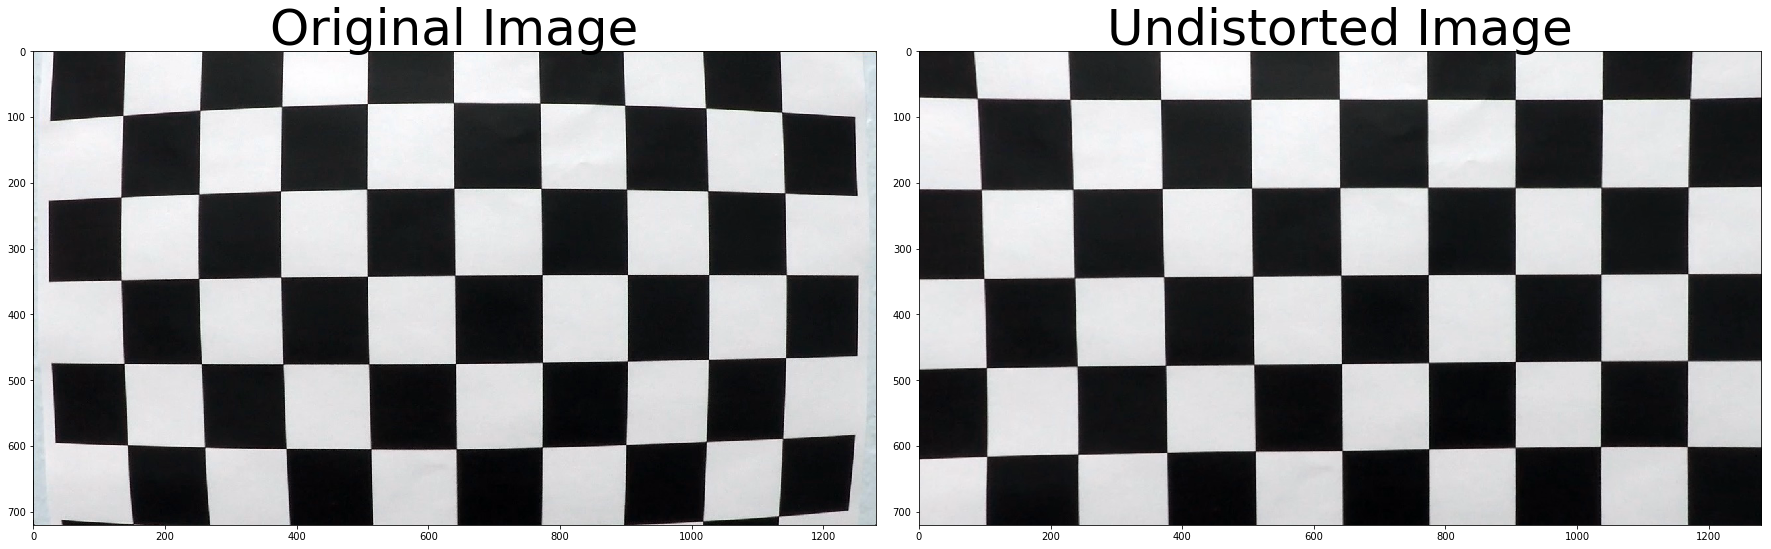

In [238]:
#perform camera calibration

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()


# Read in an image
img = cv2.imread('camera_cal/calibration1.jpg')

#Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2],None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return mtx, dist, dst

cam_mtx, dist_coef, undistorted = cal_undistort(img, objpoints, imgpoints)

print(dist_coef)

#plot original and undistorted images side by side:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

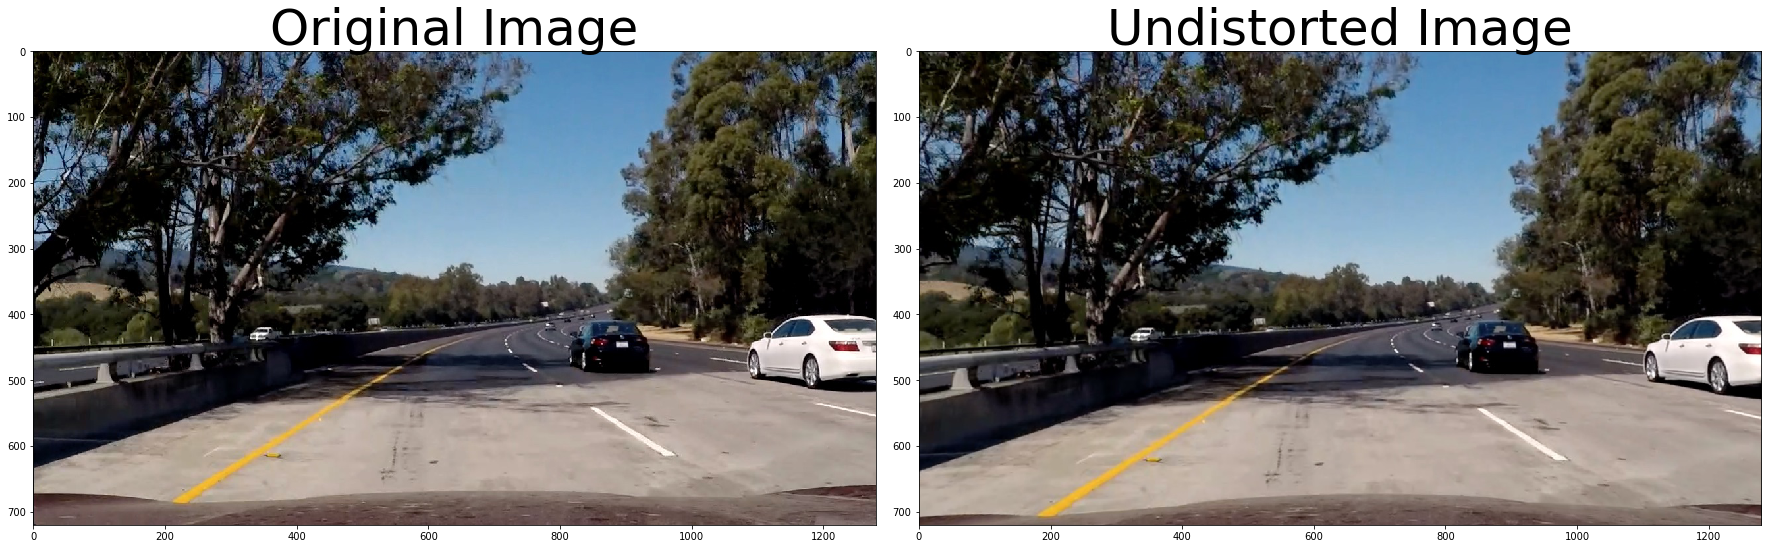

In [239]:


#apply distortion correction to raw images
#used mpimg.imread instead of cv2.imread because the colors were coming out off with cv2
testim = mpimg.imread(r'C:\Users\Vatche\Documents\Udacity\CarND-Advanced-Lane-Lines\test_images\test5.jpg')
#straight_lines1

def undistortion(image, mtx, dist):
    udt = cv2.undistort(image, mtx, dist, None, mtx)
    return udt

udt = undistortion(testim, cam_mtx, dist_coef)

#plot original and undistorted images side by side:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(testim)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(udt)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

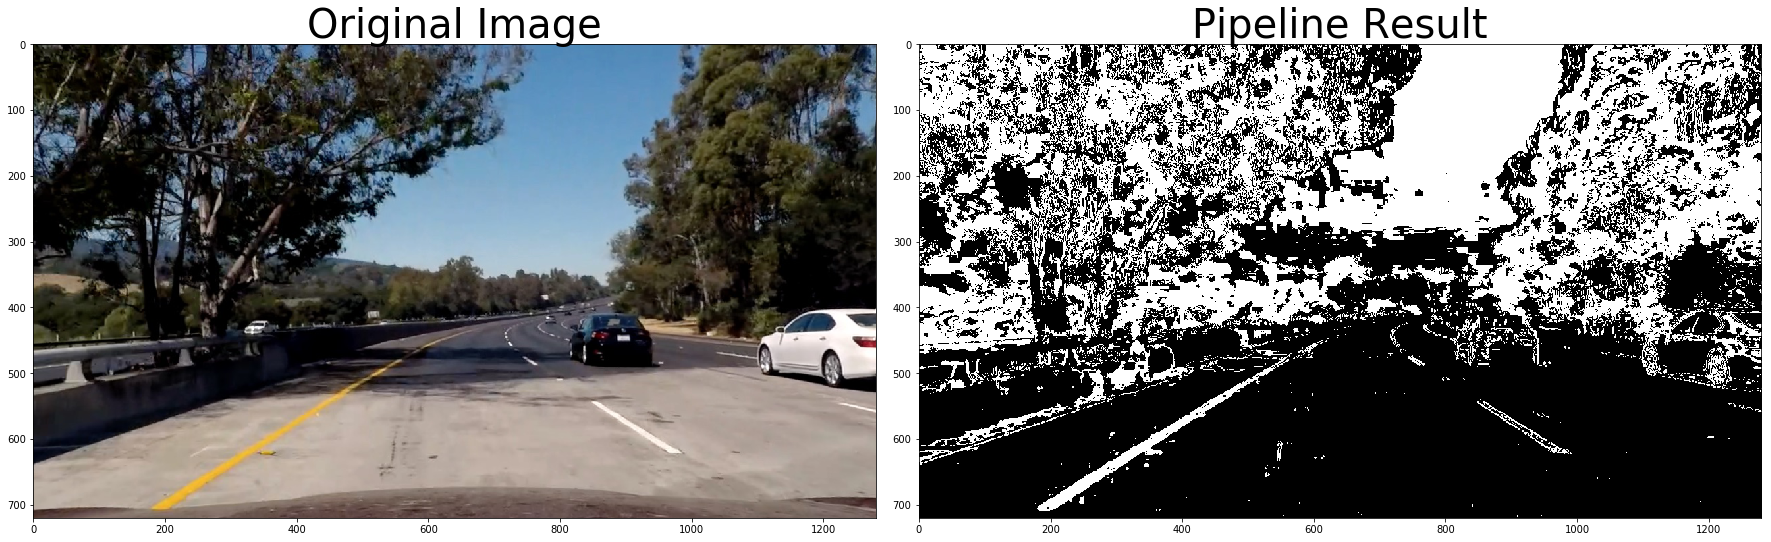

In [240]:
#use color transforms and gradients to create a thresholded binary image

#pipeline for creating thresholded binary image
def pipeline(img, s_thresh=(100, 180), h_thresh=(20, 100), l_thresh=(20, 100), sx_thresh=(20, 100)):
    
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[((s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])) | ((h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1]))] = 1
    s_binary[((s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])) & ((l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])) ] = 0
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    #overlay both the gradient and HLS color threshold lines onto one image.
    binary_total = np.zeros_like(scaled_sobel)
    binary_total[(sxbinary ==1) | (s_binary ==1)] = 1
    return binary_total
    
threshed = pipeline(udt)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(udt)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(threshed, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



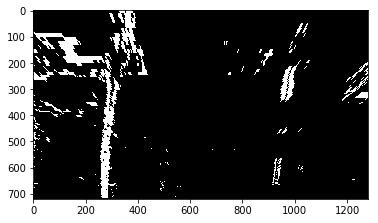

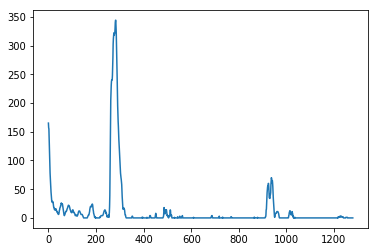

In [241]:
#apply perspective transform to rectify binary image and make a 'birds eye view'

image_size = (threshed.shape[1], threshed.shape[0]) 

#from sraight line image, we can get the 4 fixed points:
src = np.float32([[583,460],[700,460],[1105,720],[208,720]])
#[1014,660],[292,660]
#destination points where we want this points to end up in the new warped image:
dest = np.float32([[300,0],[900,0],[900,image_size[1]],[300,image_size[1]]])

#function to perform perspective transform:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

birds_eye_view = warper(threshed, src, dest)
#birds_eye_view = np.dstack(( birds_eye_view, birds_eye_view, birds_eye_view))*255 #convert to RGB colorscale
bev_lines=birds_eye_view

plt.imshow(birds_eye_view, cmap='gray')
plt.figure()
#cv2.rectangle(bev_lines,(300,0),(900,image_size[1]),(255,0,0),5) #draw the parallel lines on the transformed image
#plt.imshow(bev_lines) #show the birds eye view image

histogram = np.sum(birds_eye_view[birds_eye_view.shape[0]/2:,:], axis=0)
plt.plot(histogram)

(720, 0)

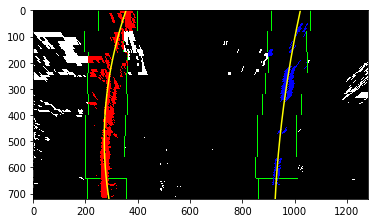

In [242]:
#detect lane pixels and fit to find lane boundary
def find_lanes(image):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(image[image.shape[0]/2:,:], axis=0)
    #plt.plot(histogram)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((image, image, image))*255
    #print(out_img)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 75
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    #np.savetxt('test.txt', left_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    #print(rightx)

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return ploty, left_fitx, right_fitx, out_img, leftx, rightx, lefty, righty
    
ploty, left_fitx, right_fitx, out_img, leftx, rightx, lefty, righty = find_lanes(birds_eye_view)
    
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [243]:
#calculate the radius of curvature in meters
def lane_curve(ploty, leftx, rightx, lefty, righty):

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

left_curverad, right_curverad = lane_curve(ploty, leftx, rightx, lefty, righty)
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m


477.007520973 m 1418.22222264 m


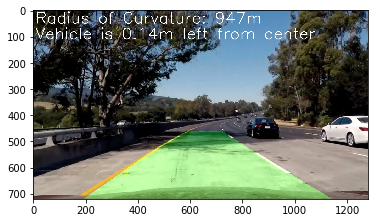

In [248]:
#warp detected lane boundaries back onto original images
def warp_back(image, left_fitx, right_fitx, ploty, original):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = cv2.getPerspectiveTransform(dest, src)
    newwarp = cv2.warpPerspective(color_warp, Minv, (udt.shape[1], udt.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original, 1, newwarp, 0.3, 0)
    
    return result, newwarp

result, newwarp = warp_back(birds_eye_view, left_fitx, right_fitx, ploty, udt)

#print the required values on the image
def print_vals(image, left_curverad, right_curverad,newwarp):
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    #average the right and left radius of curvatures
    ave_rc = (left_curverad + right_curverad)/2

    #calculate the offset from center of lane
    vals_720=newwarp[719,:,1]
    inds_720=[]
    for x in range(len(vals_720)):
        if vals_720[x] != 0:
            inds_720.append(x)

    lane_min = np.min(inds_720) #gives the left lane endpoint
    lane_max = np.max(inds_720) #gives the right lane endpoint
    #print(lane_min)
    #print(lane_max)

    center_lane = lane_min + (lane_max-lane_min)/2
    #print(center_lane)
    center_image = len(vals_720)/2
    #print(center_image)

    offset_pix = center_image - center_lane #calculate offset
    offset_m = offset_pix * xm_per_pix
    if offset_m > 0: #decide whether it is to the right or left of lane center
        sides = 'right'
    elif offset_m < 0:
        sides = 'left'

    offset_m_abs = np.absolute(offset_m)
    #print(offset_m_abs)

    #add text to the image: radius of curvature and offset from lane center
    font = cv2.FONT_HERSHEY_SIMPLEX
    rc_text = 'Radius of Curvature: %im' % ave_rc
    cv2.putText(image,rc_text,(10,50), font, 2,(255,255,255),2,cv2.LINE_AA)
    off_text = 'Vehicle is %.2fm %s from center' % (offset_m_abs,sides)
    cv2.putText(image,off_text,(10,110), font, 2,(255,255,255),2,cv2.LINE_AA)
    
    return image

result = print_vals(result, left_curverad, right_curverad, newwarp)

#show final result:
plt.imshow(result)

## Stage 2: Test on Videos
Now that the Pipeline is complete, I apply it to videos as shown below.

In [249]:
#import video editing and displaying libraries
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [250]:
#import pipeline into a function
def process_image(image):
    
    #undistort image
    udt = undistortion(image, cam_mtx, dist_coef)
    #create thresholded binary image
    threshed = pipeline(udt)
    #apply perspective transform
    birds_eye_view = warper(threshed, src, dest)
    #detect lanes
    ploty, left_fitx, right_fitx, out_img, leftx, rightx, lefty, righty = find_lanes(birds_eye_view)
    #determine lane curvature, offset
    left_curverad, right_curverad = lane_curve(ploty, leftx, rightx, lefty, righty)
    #warp lanes back on image
    result, newwarp = warp_back(birds_eye_view, left_fitx, right_fitx, ploty, udt)
    #output visual display of curvature and offset
    result = print_vals(result, left_curverad, right_curverad, newwarp)
    
    return result


In [251]:
output_vid = 'p4vid.mp4'
clip1 = VideoFileClip("project_video.mp4")
p4clip = clip1.fl_image(process_image)
#%time p4clip.write_videofile(output_vid, audio=False)
%time p4clip.write_videofile(output_vid, audio=False)

  self.nchannels))




[MoviePy] >>>> Building video p4vid.mp4
[MoviePy] Writing video p4vid.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]WARNING:py.warnings:C:\Program Files\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future

100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:52<00:00,  6.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: p4vid.mp4 

Wall time: 2min 53s


In [252]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(output_vid))

## OPTIONAL: Challenge Video
Below I tried my algorithm on the challenge video just to see how it holds up.

In [253]:
output_vid = 'p4challenge.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
p4clip = clip1.fl_image(process_image)
#%time p4clip.write_videofile(output_vid, audio=False)
%time p4clip.write_videofile(output_vid, audio=False)

  self.nchannels))




[MoviePy] >>>> Building video p4challenge.mp4
[MoviePy] Writing video p4challenge.mp4


  0%|                                                                                          | 0/485 [00:00<?, ?it/s]WARNING:py.warnings:C:\Program Files\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future

100%|███████████████████████████████████████████████████████████████████████████████▊| 484/485 [01:05<00:00,  7.27it/s]WARNING:py.warnings:C:\Program Files\Miniconda3\envs\carnd-term1\lib\site-packages\moviepy\video\io\ffmpeg_reader.py:116: UserWarning: Warning: in file challenge_video.mp4, 2764800 bytes wanted but 0 bytes read,at frame 484/485, at time 16.15/16.15 sec. Using the last valid frame instead.
  UserWarning)

100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:05<00:00,  7.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: p4challenge.mp4 

Wall time: 1min 6s


In [254]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(output_vid))